In [1]:
!pip install pandarallel

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16676 sha256=c9151f92c5ff65a5328dea5a021e99240a6a8972696830afd35bb08c2a921e6d
  Stored in directory: /home/repl/.cache/pip/wheels/c7/e9/78/48eb140b79de41c4d9440938ef5f9e3186c979183fe57829b3
Successfully built pandarallel


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
import multiprocessing
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [3]:
seasons = [2024, 2023, 2022, 2021, 2020, 2019]
leagues_dictionary = {
    'MX1': 31,
    'BR1': 24,
    'ARG1': 21,
    'MLS': 22,
    'ENG1': 9,
    'ESP1': 12,
    'ITA1': 11,
    'GER1': 20,
    'FRA1': 13,
    'HOL1': 23,
    'POR1': 32,
    'ENG2': 10

}

df_sum = pd.DataFrame()
df_def = pd.DataFrame()

for league, code in leagues_dictionary.items():
    for season in seasons:
        sum_temp = pd.read_parquet("Data/{}/{}_{}_Sum.gzip".format(league, league, season))
        def_temp = pd.read_parquet("Data/{}/{}_{}_Def.gzip".format(league, league, season))
        sum_temp['league'], def_temp['league'], sum_temp['code'], def_temp['code'], sum_temp['season'], def_temp['season'] = league, league, code, code, season, season

        df_sum = pd.concat([df_sum, sum_temp])
        df_def = pd.concat([df_def, def_temp])  
        
        
df_sum['team'] = df_sum['team'] + df_sum.league
df_def['team'] = df_def['team'] + df_def.league

df_sum['key'] = df_sum['match'] + "|" + df_sum["team"] + "|" + df_sum['rival'] + "|" + df_sum['league']
        
match_list = df_sum.groupby(['match', 'season']).agg(winner=('winner', 'first'),
                                                 league=('league', 'first'),
                                                 date=('date', 'first'),
                                                     time=('time', 'first'),
                                                    stadium=('stadium','first'),
                                                    home_manager=('home_manager', 'first'),
                                                    away_manager=('away_manager', 'first')).reset_index()

match_list['home_team'] = match_list['match'].str.split('-').str[0]
match_list['away_team'] = match_list['match'].str.split('-').str[1]

match_list['home_team'] = match_list['home_team'] + match_list.league
match_list['away_team'] = match_list['away_team'] + match_list.league

match_list['home_manager'] = match_list['home_manager'] + "-" + match_list['home_team']
match_list['away_manager'] = match_list['away_manager'] + "-" + match_list['away_team']

match_list['key'] = match_list['match'] + "|" + match_list["home_team"] + "|" + match_list['away_team'] + "|" + match_list['league']

In [4]:
def match_per_coach(row):
    home_coach = row['home_manager']
    away_coach = row['away_manager']
    date = row['date']
    
    df_temp = match_list[match_list['date'] < date]
    
    row['home_coach_matches'] = df_temp[(df_temp['home_manager'] == home_coach) | (df_temp['away_manager'] == home_coach)].shape[0]
    row['away_coach_matches'] = df_temp[(df_temp['home_manager'] == away_coach) | (df_temp['away_manager'] == away_coach)].shape[0]
    return row

In [5]:
match_list = match_list.apply(match_per_coach, axis=1)

In [6]:
match_list

match  ...  away_coach_matches
0         Ajaccio-Angers-2022-12-28  ...                   0
1        Ajaccio-Auxerre-2023-04-09  ...                  17
2          Ajaccio-Brest-2023-04-23  ...                  14
3       Ajaccio-Clermont-2022-10-02  ...                  44
4           Ajaccio-Lens-2022-08-14  ...                  36
...                             ...  ...                 ...
21275  Wycombe-Rotherham-2020-09-12  ...                   7
21276  Wycombe-Sheffield-2020-10-31  ...                  48
21277      Wycombe-Stoke-2020-12-02  ...                  45
21278    Wycombe-Swansea-2020-09-26  ...                  50
21279    Wycombe-Watford-2020-10-27  ...                   7

[21280 rows x 14 columns]

In [7]:
def a_power(df_temp):
    columns_to_normalize = ['Gls', 'Ast', 'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks',
                         'xG', 'npxG', 'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'PrgP', 'Carries', 'PrgC', 'Att_1', 'Succ']
    scaler = StandardScaler()
    df_normalized = df_temp[columns_to_normalize].copy()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized), columns=columns_to_normalize)
    
    df_normalized[['Player', 'team', 'match', 'location']] = df_temp[['Player', 'team', 'match', 'location']].values
    

    """    
    weights = {
        'Gls': 3,
        'Ast': 2,
        'Sh': 0.5,
        'SoT': 1,
        'CrdY': -1,
        'CrdR': -3,
        'Touches': 0.2,
        'Tkl': 1,
        'Int': 1,
        'Blocks': 1,
        'xG': 2,
        'npxG': 2,
        'xAG': 2,
        'SCA': 1,
        'GCA': 2,
        'Cmp': 0.5,
        'Att': 0.3,
        'PrgP': 1,
        'Carries': 0.2,
        'PrgC': 1,
        'Att_1': 0.5,
        'Succ': 1
    }
    """
    
    weights = {
        'Gls': 5,
        'Ast': 5,
        'Sh': 0.5,
        'SoT': 1,
        'CrdY': -1,
        'CrdR': -3,
        'Touches': 0.02,
        'Tkl': 1,
        'Int': 1,
        'Blocks': 1,
        'xG': 1.5,
        'npxG': 3,
        'xAG': 3,
        'SCA': 2,
        'GCA': 4,
        'Cmp': 0.5,
        'Att': 0.005,
        'PrgP': 0.5,
        'Carries': 0.5,
        'PrgC': 1,
        'Att_1': 0.2,
        'Succ': 1
    }
    
    for column in columns_to_normalize:
        df_normalized[column] *= weights[column]
    
    df_normalized['Total_Score'] = df_normalized.sum(axis=1)
    
    df_normalized = df_normalized.groupby(['Player', 'location']).mean().reset_index()

    return df_normalized[['Player', 'Total_Score', 'location']]

In [8]:
def d_power(df_temp):
    columns_to_normalize = ['Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'tc_gls']

    scaler = StandardScaler()
    df_normalized = df_temp[columns_to_normalize].copy()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized), columns=columns_to_normalize)

    df_normalized[['Player', 'team', 'match', 'location']] = df_temp[['Player', 'team', 'match', 'location']].values
    """
    weights = {
        'Tkl': 1,
        'TklW': 2,
        'Def 3rd': 1.5,
        'Mid 3rd': 1,
        'Att 3rd': 0.5,
        'Tkl1': 2,
        'Att': -1,
        'Tkl%': 1,
        'Lost': -1,
        'Blocks': 1.5,
        'Sh': 2,
        'Pass': 1.5,
        'Int': 2,
        'Tkl+Int': 2,
        'Clr': 1.5,
        'Err': -3,
        'tc_gls': -3  # Penalizamos own goals
        }
    """
    
    weights = {
        'Tkl': 1,
        'TklW': 3,
        'Def 3rd': 2,
        'Mid 3rd': 2,
        'Att 3rd': 2,
        'Tkl1': 3,
        'Att': 1.5,
        'Tkl%': 1.5,
        'Lost': -3,
        'Blocks': 3,
        'Sh': 3,
        'Pass': 0.5,
        'Int': 3,
        'Tkl+Int': 4,
        'Clr': 3,
        'Err': -4,
        'tc_gls': -8  # Penalizamos own goals
    }
    
    for column in columns_to_normalize:
        df_normalized[column] *= weights[column]
        
    df_normalized['Total_Score'] = df_normalized.sum(axis=1)
    
    df_normalized = df_normalized.groupby(['Player', 'location']).mean().reset_index()

    
    return df_normalized[['Player', 'Total_Score', 'location']]

In [9]:
def get_last_5_matches_date(team, current_date, df):
    # Filtra los partidos del equipo hasta la fecha actual
    team_matches = df[(df['team'] == team) & (df['date'] < current_date)]
    
    # Ordena por fecha descendente y toma las fechas únicas
    unique_dates = team_matches.sort_values('date', ascending=False)['date'].unique()
    
    # Si hay al menos 5 fechas, devuelve la fecha de los 5 partidos anteriores
    if len(unique_dates) >= 5:
        return unique_dates[4]
    
    # Si no hay suficientes fechas, devuelve la fecha más antigua disponible
    return unique_dates[-1] if len(unique_dates) > 0 else None

In [10]:
def a_bucket_per_match(key):
    try:
        k_split = key.split('|')

        t_match = k_split[0]
        t_team = k_split[1]
        t_rival = k_split[2]
        t_league = k_split[3]
        t_date = (dt.datetime.strptime(t_match.strip('-')[-10:], '%Y-%m-%d') - dt.timedelta(days=30)).strftime('%Y-%m-%d')
        
        local_players = df_sum[(df_sum['match'] == t_match) & (df_sum['location'] == "home")]['Player'].values
        away_players = df_sum[(df_sum['match'] == t_match) & (df_sum['location'] == "away")]['Player'].values
        
        away_players = [f"{player}-away" for player in away_players]
        local_players = [f"{player}-home" for player in local_players]
    
        
        if t_league == "BR1" or t_league == "MLS":
            t_season = int(t_match.split('-')[2])
        else:
            t_season = int(t_match.split('-')[2])  if int(t_match.split('-')[3]) < 7 else int(t_match.split('-')[2]) + 1

        # Own Buckets

        # Obtenemos los dataframes
        o_df_all = df_sum[(df_sum['date'] < t_date) & (df_sum['league'] == t_league)]
        o_df_season = df_sum[(df_sum['season'] == t_season) & (df_sum['league'] == t_league)]
        o_df_last5 = df_sum[(df_sum['date'] > t_date) & (df_sum['league'] == t_league)]

        
        
        # Obtenemos los powers
        a_power_all = a_power(o_df_all)
        a_power_season = a_power(o_df_season)
        a_power_last5 = a_power(o_df_last5)
        
        

        o_buckets = a_power_all.merge(a_power_season, on=["Player", 'location'], suffixes=["_all","_season"], how="left").merge(a_power_last5, on=["Player", 'location'], suffixes=["_all","_season", "_last5"], how="left")
        
        o_buckets['Player'] = o_buckets['Player'] + "-" + o_buckets['location']

        o_buckets['total'] = ((o_buckets['Total_Score_all'].fillna(o_buckets.mean(axis=1)) +
                      o_buckets['Total_Score_season'].fillna(o_buckets.mean(axis=1)) +
                      o_buckets['Total_Score'].fillna(o_buckets.mean(axis=1)) * 3) / 5) * 10
        
        
        local_a_power = o_buckets[o_buckets['Player'].isin(local_players)]['total'].mean()
        away_a_power = o_buckets[o_buckets['Player'].isin(away_players)]['total'].mean()
        
        return local_a_power, away_a_power
    except:
        return None, None



def d_bucket_per_match(key):
    try:
        k_split = key.split('|')

        t_match = k_split[0]
        t_team = k_split[1]
        t_rival = k_split[2]
        t_league = k_split[3]
        t_date = (dt.datetime.strptime(t_match.strip('-')[-10:], '%Y-%m-%d') - dt.timedelta(days=30)).strftime('%Y-%m-%d')

        local_players = df_def[(df_def['match'] == t_match) & (df_def['location'] == "home")]['Player'].values
        away_players = df_def[(df_def['match'] == t_match) & (df_def['location'] == "away")]['Player'].values
        
        away_players = [f"{player}-away" for player in away_players]
        local_players = [f"{player}-home" for player in local_players]
        
        if t_league == "BR1" or t_league == "MLS":
            t_season = int(t_match.split('-')[2])
        else:
            t_season = int(t_match.split('-')[2])  if int(t_match.split('-')[3]) < 7 else int(t_match.split('-')[2]) + 1

        # Own Buckets

        # Obtenemos los dataframes
        df_all = df_def[(df_def['date'] < t_date) & (df_def['league'] == t_league)]
        df_season = df_def[(df_def['season'] == t_season) & (df_def['league'] == t_league)]
        df_last5 = df_def[(df_def['date'] > t_date) & (df_def['league'] == t_league)]

        d_power_all = d_power(df_all)
        d_power_season = d_power(df_season)
        d_power_last5 = d_power(df_last5)

        d_buckets = d_power_all.merge(d_power_season, on=["Player", 'location'], suffixes=['_all', '_season'], how='left').merge(d_power_last5, how='left', on=["Player", 'location'])

        d_buckets['Player'] = d_buckets['Player'] + "-" + d_buckets['location']
        

        d_buckets['total'] = ((d_buckets['Total_Score_all'].fillna(d_buckets.mean(axis=1)) +
                      d_buckets['Total_Score_season'].fillna(d_buckets.mean(axis=1)) +
                      d_buckets['Total_Score'].fillna(d_buckets.mean(axis=1)) * 3) / 5) * 10

        local_d_power = d_buckets[d_buckets['Player'].isin(local_players)]['total'].mean()
        away_d_power = d_buckets[d_buckets['Player'].isin(away_players)]['total'].mean()
        

        return local_d_power, away_d_power
    except:
        return None, None

In [11]:
match_list

match  ...  away_coach_matches
0         Ajaccio-Angers-2022-12-28  ...                   0
1        Ajaccio-Auxerre-2023-04-09  ...                  17
2          Ajaccio-Brest-2023-04-23  ...                  14
3       Ajaccio-Clermont-2022-10-02  ...                  44
4           Ajaccio-Lens-2022-08-14  ...                  36
...                             ...  ...                 ...
21275  Wycombe-Rotherham-2020-09-12  ...                   7
21276  Wycombe-Sheffield-2020-10-31  ...                  48
21277      Wycombe-Stoke-2020-12-02  ...                  45
21278    Wycombe-Swansea-2020-09-26  ...                  50
21279    Wycombe-Watford-2020-10-27  ...                   7

[21280 rows x 14 columns]

In [12]:
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=6)

df_sample = match_list[match_list['season']!=2019]
df_sample = match_list[match_list['league'].isin(["MX1", "ARG1", "BR1", "MLS", "ENG1", "ESP1"])]

def process_sample(row):
    a_result = a_bucket_per_match(row['key'])
    d_result = d_bucket_per_match(row['key'])

    row['home_ap'] = a_result[0] if len(a_result) > 0 else None
    row['home_dp'] = d_result[0] if len(d_result) > 0 else None  # Fix the condition here
    
    row['away_ap'] = a_result[1] if len(a_result) > 0 else None
    row['away_dp'] = d_result[1] if len(d_result) > 0 else None  # Fix the condition here
    return row


df_sample = df_sample.parallel_apply(process_sample, axis=1)

df_sample['home_gp'] = df_sample['home_ap'] + df_sample['home_dp']
df_sample['away_gp'] = df_sample['away_ap'] + df_sample['away_dp']

df_sample['home_win'] = df_sample['home_ap'] - df_sample['away_dp']
df_sample['away_win'] = df_sample['away_ap'] - df_sample['home_dp']

df_sample['home_win_var'] = df_sample['home_gp'] - df_sample['away_gp']
df_sample['away_win_var'] = df_sample['away_gp'] - df_sample['home_gp']

df_sample = df_sample[['match', 'home_win', 'away_win', 'home_win_var', 'away_win_var', 'winner', 'home_gp', 'away_gp', 'league']]

df_sample.to_parquet('Data/Match_List_w_buckets_league_basedv2.gzip', compression='gzip')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [186]:
df_sample = pd.read_parquet('Data/Match_List_w_buckets_league_basedv2.gzip')
df_sample.dropna(inplace=True)
df_sample

match   home_win  ...     away_gp  league
19      Alavés-Almería-2023-11-05  69.658224  ... -119.622694    ESP1
20     Alavés-Athletic-2018-12-17 -53.934341  ...   -3.486975    ESP1
21     Alavés-Athletic-2020-02-23 -67.481041  ...   17.609648    ESP1
22     Alavés-Athletic-2020-10-04   5.114681  ...  -43.329973    ESP1
23     Alavés-Athletic-2022-01-09 -22.549440  ...    0.060841    ESP1
...                           ...        ...  ...         ...     ...
21252      Wolves-West-2019-12-04  -2.250006  ...  -23.549989    ENG1
21253      Wolves-West-2021-01-16   8.811432  ...  -56.294850    ENG1
21254      Wolves-West-2021-04-05 -13.163508  ...  -14.385512    ENG1
21255      Wolves-West-2021-11-20 -21.842425  ...   -9.519607    ENG1
21256      Wolves-West-2023-01-14  -5.596072  ...  -16.888740    ENG1

[11796 rows x 9 columns]

In [187]:
df_sample = df_sample.drop_duplicates(subset='match', keep='first')
match_list = match_list.drop_duplicates(subset='match', keep='first')

In [188]:
# First, we need to load the 'match_list' data to get the 'date' information
# Assuming 'match_list' is a parquet file similar to 'Match_List_w_buckets_league_based.gzip'

# Now, let's convert the 'date' column to datetime format
match_list['date'] = pd.to_datetime(match_list['date'])

# Now, let's extract the week from the 'date' column
# Assuming 'date' is in a standard datetime format, we can use dt.isocalendar().week
match_list['week'] = match_list['date'].dt.isocalendar().week

# Now, let's extract the day of the week from the 'date' column
match_list['day_of_week'] = match_list['date'].dt.dayofweek + 1


# Asegúrate de que no haya duplicados en la columna 'match' en ambos DataFrames
if match_list['match'].duplicated().any() or df_sample['match'].duplicated().any():
    raise ValueError("La columna 'match' tiene duplicados en al menos uno de los DataFrames. Verifica y elimina duplicados antes de continuar.")

# Realiza el merge basado en el identificador único 'match'
df_sample = df_sample.merge(match_list[['match', 'week', 'day_of_week', 'home_coach_matches', 'away_coach_matches']], on='match', how='left')

# Muestra el DataFrame actualizado
print(df_sample.head())


                        match  ...  away_coach_matches
0   Alavés-Almería-2023-11-05  ...                   2
1  Alavés-Athletic-2018-12-17  ...                   1
2  Alavés-Athletic-2020-02-23  ...                  48
3  Alavés-Athletic-2020-10-04  ...                  65
4  Alavés-Athletic-2022-01-09  ...                  41

[5 rows x 13 columns]


In [189]:
df_sample['coach_diff'] = df_sample['home_coach_matches'] - df_sample['away_coach_matches']

In [190]:
# Calculate the probability of getting "away" in "winner" when coach_diff is less than zero
prob_away = len(df_sample[(df_sample['winner'] == "home") & (df_sample['coach_diff'] >= 0)]) / len(df_sample[(df_sample['winner'] == "home")])

prob_away

0.6070103092783505

In [191]:
import numpy as np
df_sample['home_win'] = np.where(df_sample['home_coach_matches'] > 50, df_sample['home_win'] * 1.50, df_sample['home_win'])
df_sample['away_win'] = np.where(df_sample['away_coach_matches'] > 50, df_sample['away_win'] * 1.50, df_sample['away_win'])

<AxesSubplot: xlabel='home_win', ylabel='away_win'>

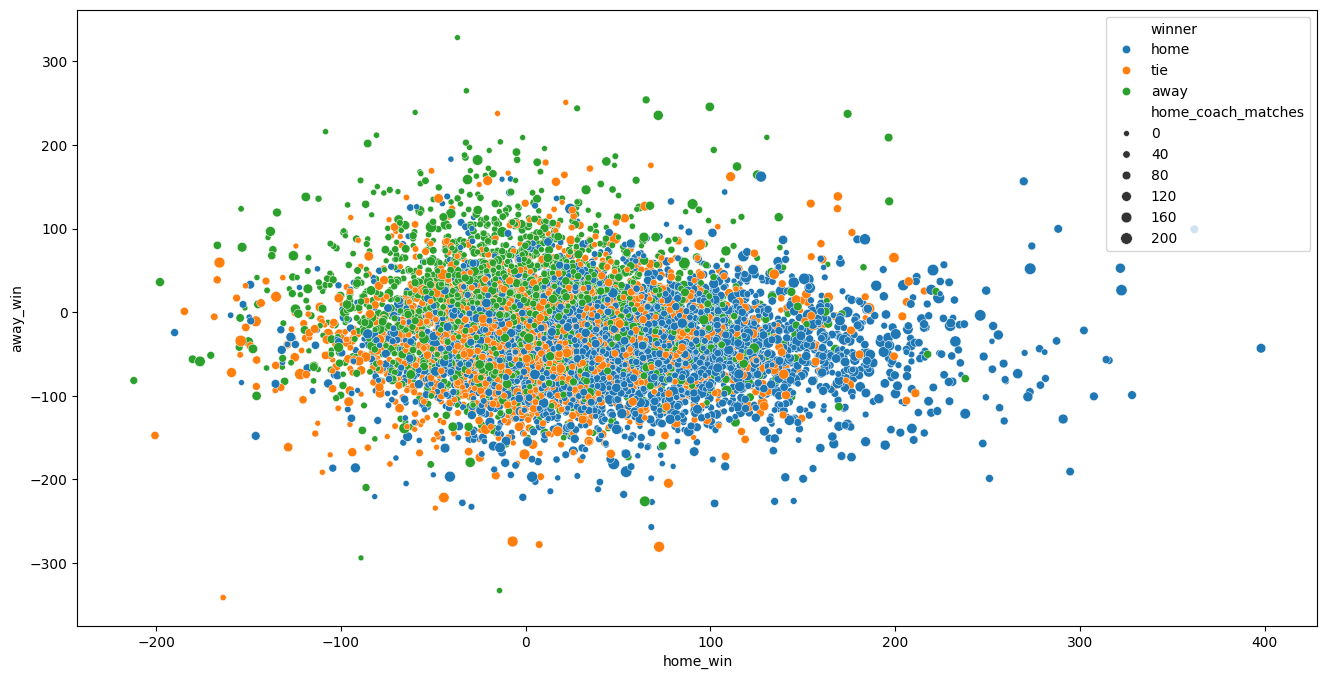

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.scatterplot(data=df_sample, x=df_sample["home_win"], y=df_sample["away_win"], hue="winner", size="home_coach_matches")

In [203]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

X = df_sample[['home_win', 'away_win', "home_win_var", "away_win_var"]].values
y = df_sample['winner'].values

# Impute missing values with mean
imputer = SimpleImputer()
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=5)

knn = KNeighborsClassifier(n_neighbors=6000, weights="distance")
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.5280898876404494


In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Supongamos que 'league' es una variable categórica en tu conjunto de datos
X = df_sample[['home_win', 'away_win', 'league', 'week']].values
y = df_sample['winner'].values

# Imputa valores faltantes con la media
imputer = SimpleImputer()
X[:, :2] = imputer.fit_transform(X[:, :2])  # Solo imputamos las dos primeras columnas

# Definir transformador para aplicar one-hot encoding solo a la columna 'league'
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), [2])  # 'league' es la tercera columna (índice 2)
    ],
    remainder='passthrough'
)

# Crear el pipeline con el preprocesamiento y el clasificador KNN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=1000, weights='distance'))
])

# División de conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Entrenar el modelo usando el pipeline
pipeline.fit(X_train, y_train)

# Calcular y mostrar la precisión del modelo en el conjunto de prueba
accuracy = pipeline.score(X_test, y_test)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')

Precisión del modelo: 53.65%
